In [1]:
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql.functions import col, size
import pyspark.sql.functions as fn

In [2]:
# Start spark in local mode using 100gb of memory
# local mode only runs on a single node, but it will utilize all cores (We have 48!)
conf = SparkConf().setAppName("test") \
    .set('spark.driver.memory','54g') \
    .set('spark.jars.packages', 'graphframes:graphframes:0.6.0-spark2.3-s_2.11') \
    .setMaster("local[44]")
#.setMaster("yarn") # this is used when we run on hadoop, ignore for now

sc = SparkContext(conf = conf)
sqlContext = SQLContext(sc)

print("Spark Version: ", sc.version)
print("defaultParallelism: ", sc.defaultParallelism)
print("Spark WebURLL ", sc.uiWebUrl) # you can view running jobs here, but I am only able to connect to it via VNC rn, maybe SSH tunneling will fix this? idk

Spark Version:  2.4.4
defaultParallelism:  44
Spark WebURLL  http://c251-135.wrangler.tacc.utexas.edu:4040


In [3]:
from functools import reduce
from pyspark.sql.functions import col, lit, when
from graphframes import *

In [4]:
import json
from pyspark.sql.types import StructType

# load data from the json file (we can also do the csv when we have it)

#schema_json = sqlContext.read.text("/data/06836/ychang5/schema.json").first()[0]
#schema = StructType.fromJson(json.loads(schema_json))

#flat_df = sqlContext.read.json('/data/06836/ychang5/ut_venmo_2018_flat.json', schema = schema)

In [36]:
nodes_path = '/data/06836/ychang5/nodes.json'
nodes_schema_json = sqlContext.read.text("/data/06836/ychang5/nodes_schema.json").first()[0]
nodes_schema = StructType.fromJson(json.loads(nodes_schema_json))


edges_path = '/data/06836/ychang5/edges.json'
edges_schema_json = sqlContext.read.text("/data/06836/ychang5/edges_schema.json").first()[0]
edges_schema = StructType.fromJson(json.loads(edges_schema_json))

nodes = sqlContext.read.json(nodes_path, \
                             schema = nodes_schema \
                            )
edges = sqlContext.read.json(edges_path, \
                             schema = edges_schema \
                            )

# If type is charge (payment flows from dst to src)
# flip src and dst

In [37]:
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType

src_2 = udf(lambda src, dst, typ: dst if typ == 'charge' else src , LongType())
dst_2 = udf(lambda src, dst, typ: src if typ == 'charge' else dst , LongType())

In [38]:
nodes2 = nodes.select('id')
edges2 = edges.select('src', 'dst', 'type')

In [39]:
edges3 = edges2.withColumn("src2", src_2(edges2.src, edges2.dst, edges2.type))
edges4 = edges3.withColumn('dst2', dst_2(edges3.src, edges3.dst, edges3.type))

In [40]:
edges5 = edges4.selectExpr("src2 as src", "dst2 as dst")

In [44]:
edges6 = edges5.distinct()

In [45]:
edges5.count()

342281006

In [46]:
edges6.count()

132486104

In [47]:
G2 = GraphFrame(nodes2, edges6)

In [48]:
motifs = G2.find("(a)-[e]->(b); (b)-[e2]->(a)")

In [49]:
motifs.show()

+---------+---------------+------+---------------+
|        a|              e|     b|             e2|
+---------+---------------+------+---------------+
|  [55976]|    [55976, 11]|  [11]|    [11, 55976]|
|[1315774]|  [1315774, 13]|  [13]|  [13, 1315774]|
|[2489219]|  [2489219, 46]|  [46]|  [46, 2489219]|
| [746556]|  [746556, 112]| [112]|  [112, 746556]|
|[6060547]| [6060547, 158]| [158]| [158, 6060547]|
|  [87794]|   [87794, 173]| [173]|   [173, 87794]|
| [928039]|  [928039, 224]| [224]|  [224, 928039]|
|[3342324]| [3342324, 830]| [830]| [830, 3342324]|
|   [6675]|   [6675, 1009]|[1009]|   [1009, 6675]|
|[2178910]|[2178910, 1164]|[1164]|[1164, 2178910]|
|[1580380]|[1580380, 1390]|[1390]|[1390, 1580380]|
|[2713897]|[2713897, 1649]|[1649]|[1649, 2713897]|
|      [3]|      [3, 1891]|[1891]|      [1891, 3]|
|[4878527]|[4878527, 2025]|[2025]|[2025, 4878527]|
| [378418]| [378418, 2774]|[2774]| [2774, 378418]|
| [110735]| [110735, 3233]|[3233]| [3233, 110735]|
| [171964]| [171964, 3439]|[343

In [50]:
motifs.count()

48566155

In [52]:
motifs.coalesce(1).write.format('json').save('/data/06836/ychang5/reciprical_flows_of_money.json')

There are 342281006 total edges in edges5, in edges5 we dont care about whether it was a payment or a charge anymore, we made our directed edges represent the flow of money.

Note that there are duplicate edges:
a->b
a->b
b->a

representing:
two instances that a paid b, whether by a paying b or by a completing a charge from b
and one instance of b paying a







If we take edges5.distinct(), we get edges6.

duplicate flows of money from a->b would get collapsed down to a single edge.
a->b
b->a

At this point, the size is 132486104




When we calculate the motif 
`G2.find("(a)-[e]->(b); (b)-[e2]->(a)")`


We get a dataframe, each row of which representing two rows from the graph G2 it was calculated from.
this dataframe was 48566155 in size.


meaning that there were 48566155 pairs of users (a, b) such that the edges a->b and b->a both existed in edges6, coming from 48566155 * 2 edges in the original graph.






# Interpretations of this

Cold Hard e cash had a reciprocity of 0.147, it is unknown whether they collapsed duplicate payments down.


Based on the traditional interpretation of reciprocity: 
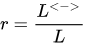


We'd say the reciprocity is

$r = \frac{48566155*2 } {132486104} = 0.73315092728$

# IGNORE BEYOND 

In [93]:
len(lst)
lst[0]

sys.getsizeof(lst[0])

64

In [94]:
import pickle
import os
os.remove('edges_src_dst.file')
with open('edges_src_dst.file', 'wb') as f2:
    pickle.dump(lst, f2)
    f2.close()

In [69]:
import sys
sys.maxsize

9223372036854775807

In [ ]:
edges_list = [(edge.src, edge.dst) for edge in edges_list]

In [33]:
nodes_list = nodes2.collect()

nodes_list = [node.id for node in nodes_list]

In [34]:
edges_list = edges2.collect()

edges_list = [(edge.src, edge.dst) for edge in edges_list]

In [36]:
import networkx as nx

In [95]:
list(nx.edge_bfs(nx.Graph(lst), lst[0][0]))

NetworkXError: Input is not a valid edge list

10000

In [1]:
list(nx.shortest_path_length(nx.Graph(lst), lst[0][0]))

NameError: name 'nx' is not defined

[(9820177, {9820177: 0, 4684918: 1}),
 (4684918, {4684918: 0, 9820177: 1}),
 (7259291, {7259291: 0, 11933486: 1}),
 (11933486, {11933486: 0, 7259291: 1}),
 (4127796, {4127796: 0, 4653211: 1}),
 (4653211, {4653211: 0, 4127796: 1}),
 (14505471, {14505471: 0, 16568480: 1}),
 (16568480, {16568480: 0, 14505471: 1}),
 (61487, {61487: 0, 8268646: 1}),
 (8268646, {8268646: 0, 61487: 1}),
 (1693689, {1693689: 0, 638295: 1}),
 (638295, {638295: 0, 1693689: 1}),
 (22793215, {22793215: 0, 15435891: 1}),
 (15435891, {15435891: 0, 22793215: 1}),
 (24889872, {24889872: 0, 28662219: 1}),
 (28662219, {28662219: 0, 24889872: 1}),
 (7347462, {7347462: 0, 7765508: 1}),
 (7765508, {7765508: 0, 7347462: 1}),
 (4840407, {4840407: 0, 5125172: 1}),
 (5125172, {5125172: 0, 4840407: 1}),
 (5337476, {5337476: 0, 509994: 1}),
 (509994, {509994: 0, 5337476: 1}),
 (3081069, {3081069: 0, 7834418: 1}),
 (7834418, {7834418: 0, 3081069: 1}),
 (3554251, {3554251: 0, 12124522: 1}),
 (12124522, {12124522: 0, 3554251: 1}),


+--------+
|      id|
+--------+
|  452763|
|  848270|
|  942995|
| 1748488|
| 3982784|
| 4358342|
| 5248593|
| 7338104|
| 7451421|
|13656247|
+--------+
only showing top 10 rows



+--------+-----------------+---------+
|    from|               e0|       to|
+--------+-----------------+---------+
|[452763]|[452763, 1555214]|[1555214]|
+--------+-----------------+---------+



id=136996 id!=136996


KeyboardInterrupt: 

In [13]:
nodes = sc.parallelize([[1],[2],[3]])
nodes = nodes.toDF()
nodes = nodes.toDF("id")

In [14]:
edges = sc.parallelize([[1,2], [2,3]]).toDF(("src", "dst"))

In [15]:
G2 = GraphFrame(nodes, edges)
print(G2)

GraphFrame(v:[id: bigint], e:[src: bigint, dst: bigint])


In [16]:
G2.vertices.show()
G2.edges.show()

+---+
| id|
+---+
|  1|
|  2|
|  3|
+---+

+---+---+
|src|dst|
+---+---+
|  1|  2|
|  2|  3|
+---+---+



In [18]:
G2.bfs('id=1', 'id!=1', maxPathLength = 10).show()

+----+------+---+
|from|    e0| to|
+----+------+---+
| [1]|[1, 2]|[2]|
+----+------+---+



In [19]:
import networkx as nx

In [ ]:
nodes = [0, 1, 2, 3]
edges = [(0, 1), (1, 0), (1, 0), (2, 0), (2, 1), (3, 1)]
